# Convolutional LSTM for coordinate prediction

### Imports

In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [3]:
length_trajectory = 10
batch_size = 128

# split and shuffle data
train_data, test_data = preprocess.split_data_for_trajectories(
    oracle_reversed_data, 0.8, length_trajectory
)
train_imgs, train_pos = preprocess.process_trajectory(train_data)
test_imgs, test_pos = preprocess.process_trajectory(test_data)

# stage data for the DataLoader
train_data = preprocess.ObtainDataset_notransform(train_imgs, train_pos)
test_data = preprocess.ObtainDataset_notransform(test_imgs, test_pos)

# DataLoader
dataset_loader_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Initialize models

In [4]:
# initialize network
net_cnn = nets.CNN_coords()
net_lstm = nets.LSTM_coords(length_trajectory)

# checking values
h0 = torch.randn(2, 10, 100)
c0 = torch.randn(2, 10, 100)
x = torch.rand((64, 10, 3, 32, 32))

# check network
features = net_cnn(x)
out0, out1, hidden, c = net_lstm(features, h0, c0)

# shape statistics
tools.shapes(x, features, hidden, out0)

# network summary
print("SUMMARY CNN \n", summary(net_cnn, (64, 10, 3, 32, 32)), "\n")
print("SUMMARY LSTM \n", summary(net_lstm, ((64, 10, 480), (2, 10, 100), (2, 10, 100))))

input cnn: torch.Size([64, 10, 3, 32, 32]) - Batch size, Channel out, Height out, Width out
output cnn: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
input lstm: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
hidden lstm: torch.Size([10, 100])
output lstm: torch.Size([64, 10]) 

SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN_coords                               [64, 10, 480]             --
├─Conv2d: 1-1                            [640, 10, 28, 28]         760
├─Conv2d: 1-2                            [640, 20, 24, 24]         5,020
├─MaxPool2d: 1-3                         [640, 20, 12, 12]         --
├─Conv2d: 1-4                            [640, 30, 8, 8]           15,030
├─MaxPool2d: 1-5                         [640, 30, 4, 4]           --
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
Total mult-adds (G): 2.85
Input size (MB): 7.86
Forward/backward pass size (MB): 108.95
P

In [5]:
inputs, label = next(iter(train_data))
print(len(inputs))
inputs = torch.stack(inputs)
inputs = torch.swapaxes(inputs, 0, 1)
print(len(x))

net_cnn = nets.CNN_coords()

encoded = net_cnn(x)
print(encoded)

10
64
tensor([[[0.0199, 0.0327, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
         [0.0016, 0.0031, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0147, 0.0192, 0.0120,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0159, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0152, 0.0207, 0.0182,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0419, 0.0107,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0201, 0.0046, 0.0269,  ..., 0.0000, 0.0000, 0.0000],
         [0.0172, 0.0306, 0.0202,  ..., 0.0000, 0.0000, 0.0000],
         [0.0108, 0.0091, 0.0357,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0235, 0.0214, 0.0251,  ..., 0.0000, 0.0000, 0.0000],
         [0.0077, 0.0000, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
         [0.0046, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0277, 0.0040, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
         [0.0234, 0.0084, 0.0099,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0135, 0.0140,  ..., 0.0000, 0.00

### Train model

In [10]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.01)
episodes = 100

(
    train_loss,
    test_loss,
    train_dis,
    test_dis,
    train_dis_item,
    test_dis_item,
) = train.train_ConvLSTM(
    dataset_loader_train_data,
    dataset_loader_test_data,
    net_cnn,
    net_lstm,
    criterion,
    optimizer,
    episodes,
    length_trajectory,
)

Progress:   0%|          | 0/100 [00:00<?, ? Episode/s]

tensor([[[224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [225.1723, 219.8814, 214.4337,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [215.7441, 222.5799, 227.8029,  ...,   0.0000,   0.0000,   0.0000]],

        [[183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [177.2545, 175.7509, 177.5666,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [179.2116, 184.9541, 198.1108,  ...,   0.0000,   0.0000,   0.0000]],

        [[216.1236, 240.7183, 248.6965,  ...

tensor([[[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.5606, 242.0756, 238.6624,  ...,   0.0000,   0.0000,   0.0000],
         [250.7303, 243.5228, 239.8501,  ...,   0.0000,   0.0000,   0.0000],
         [251.7254, 244.8836, 241.0460,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [245.0671, 242.8205, 231.1189,  ...,   0.0000,   0.0000,   0.0000],
         [238.0894, 223.7223, 201.7125,  ...,   0.0000,   0.0000,   0.0000],
         [211.1000, 192.0021, 181.3191,  ...,   0.0000,   0.0000,   0.0000]],

        [[193.3913, 182.1704, 179.4837,  ...

tensor([[[224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [225.1723, 219.8814, 214.4337,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [215.7441, 222.5799, 227.8029,  ...,   0.0000,   0.0000,   0.0000]],

        [[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.5606, 242.0756, 238.6624,  ...

tensor([[[178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [173.4034, 172.7212, 176.2774,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [186.6589, 185.7841, 186.9676,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.5606, 242.0756, 238.6624,  ...,   0.0000,   0.0000,   0.0000],
         [250.7303, 243.5228, 239.8501,  ...,   0.0000,   0.0000,   0.0000],
         [251.7254, 244.8836, 241.0460,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [245.0671, 242.8205, 231.1189,  ...,   0.0000,   0.0000,   0.0000],
         [238.0894, 223.7223, 201.7125,  ...,   0.0000,   0.0000,   0.0000],
         [211.1000, 192.0021, 181.3191,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...

tensor([[[196.8852, 194.9105, 196.0303,  ...,   0.0000,   0.0000,   0.0000],
         [200.8407, 198.3390, 199.2854,  ...,   0.0000,   0.0000,   0.0000],
         [204.8734, 201.9091, 202.6957,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [212.0855, 216.4914, 218.0370,  ...,   0.0000,   0.0000,   0.0000],
         [216.0192, 217.2562, 209.5890,  ...,   0.0000,   0.0000,   0.0000],
         [212.7674, 202.8461, 187.6969,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[235.7392, 242.7278, 244.6743,  ...

tensor([[[249.1347, 250.6058, 250.5781,  ...,   0.0000,   0.0000,   0.0000],
         [249.2587, 251.2788, 251.2578,  ...,   0.0000,   0.0000,   0.0000],
         [249.3160, 251.8337, 251.7619,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.6396, 254.0040, 253.4795,  ...,   0.0000,   0.0000,   0.0000],
         [248.5687, 254.3442, 253.6883,  ...,   0.0000,   0.0000,   0.0000],
         [248.4907, 254.6273, 253.8576,  ...,   0.0000,   0.0000,   0.0000]],

        [[209.6316, 232.3117, 240.2907,  ...,   0.0000,   0.0000,   0.0000],
         [237.4833, 241.5230, 243.6438,  ...,   0.0000,   0.0000,   0.0000],
         [241.2827, 245.4270, 249.0151,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.1061, 221.0995, 217.6436,  ...,   0.0000,   0.0000,   0.0000],
         [224.8146, 221.1691, 218.6480,  ...,   0.0000,   0.0000,   0.0000],
         [226.0726, 221.8435, 219.9412,  ...,   0.0000,   0.0000,   0.0000]],

        [[244.1256, 240.6305, 239.6331,  ...

tensor([[[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[231.4467, 230.9016, 229.9577,  ...,   0.0000,   0.0000,   0.0000],
         [229.8148, 229.1901, 228.1869,  ...,   0.0000,   0.0000,   0.0000],
         [228.0406, 227.3446, 226.3076,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.5790, 221.4900, 218.4079,  ...,   0.0000,   0.0000,   0.0000],
         [223.9769, 221.7402, 217.9832,  ...,   0.0000,   0.0000,   0.0000],
         [224.4856, 222.3102, 218.2920,  ...,   0.0000,   0.0000,   0.0000]],

        [[221.6998, 220.2581, 220.0487,  ...

tensor([[[213.3586, 213.0812, 212.6783,  ...,   0.0000,   0.0000,   0.0000],
         [210.6611, 210.3541, 209.9996,  ...,   0.0000,   0.0000,   0.0000],
         [207.7666, 207.3996, 207.0872,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [191.0311, 190.3856, 190.0261,  ...,   0.0000,   0.0000,   0.0000],
         [187.3377, 186.6339, 186.2883,  ...,   0.0000,   0.0000,   0.0000],
         [183.8457, 182.8966, 182.5580,  ...,   0.0000,   0.0000,   0.0000]],

        [[210.0607, 213.6178, 219.9211,  ...,   0.0000,   0.0000,   0.0000],
         [213.0298, 210.4840, 211.9646,  ...,   0.0000,   0.0000,   0.0000],
         [219.9922, 214.8640, 210.9766,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.6752, 217.7467, 214.8353,  ...,   0.0000,   0.0000,   0.0000],
         [223.6669, 217.9502, 215.8257,  ...,   0.0000,   0.0000,   0.0000],
         [223.6055, 218.2526, 216.6009,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.4348, 216.0438, 208.9762,  ...

tensor([[[243.7650, 250.7414, 249.3065,  ...,   0.0000,   0.0000,   0.0000],
         [243.5319, 250.2404, 248.7385,  ...,   0.0000,   0.0000,   0.0000],
         [243.3242, 249.7689, 248.2109,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [241.8678, 246.9573, 245.3574,  ...,   0.0000,   0.0000,   0.0000],
         [241.5262, 246.2079, 244.5818,  ...,   0.0000,   0.0000,   0.0000],
         [241.1432, 245.4143, 243.7779,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.7110, 221.7572, 217.2455,  ...,   0.0000,   0.0000,   0.0000],
         [220.1584, 216.6101, 220.5671,  ...,   0.0000,   0.0000,   0.0000],
         [217.3706, 222.3663, 226.8901,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [222.3976, 222.3758, 222.6689,  ...,   0.0000,   0.0000,   0.0000],
         [220.2010, 220.1568, 220.4743,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[207.5031, 207.6876, 208.3579,  ...

tensor([[[207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [212.9620, 213.3591, 213.9053,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[201.1118, 201.2032, 202.0496,  ...,   0.0000,   0.0000,   0.0000],
         [197.6855, 197.6406, 198.6205,  ...,   0.0000,   0.0000,   0.0000],
         [194.4204, 194.2311, 195.4109,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.1182, 176.6820, 178.9126,  ...,   0.0000,   0.0000,   0.0000],
         [174.7250, 174.4963, 177.0044,  ...,   0.0000,   0.0000,   0.0000],
         [172.8785, 173.3204, 176.5927,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.7110, 221.7572, 217.2455,  ...

tensor([[[196.8852, 194.9105, 196.0303,  ...,   0.0000,   0.0000,   0.0000],
         [200.8407, 198.3390, 199.2854,  ...,   0.0000,   0.0000,   0.0000],
         [204.8734, 201.9091, 202.6957,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [212.0855, 216.4914, 218.0370,  ...,   0.0000,   0.0000,   0.0000],
         [216.0192, 217.2562, 209.5890,  ...,   0.0000,   0.0000,   0.0000],
         [212.7674, 202.8461, 187.6969,  ...,   0.0000,   0.0000,   0.0000]],

        [[218.8107, 238.6060, 242.3560,  ...,   0.0000,   0.0000,   0.0000],
         [219.9449, 238.4289, 241.3932,  ...,   0.0000,   0.0000,   0.0000],
         [221.3057, 238.1648, 240.3798,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [229.6303, 235.1550, 234.0409,  ...,   0.0000,   0.0000,   0.0000],
         [231.6410, 235.1285, 232.5327,  ...,   0.0000,   0.0000,   0.0000],
         [233.7874, 235.1841, 230.7611,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...

tensor([[[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[223.8949, 223.8873, 225.8191,  ...,   0.0000,   0.0000,   0.0000],
         [224.9050, 228.0264, 229.9710,  ...,   0.0000,   0.0000,   0.0000],
         [228.9808, 230.3424, 227.5887,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [208.8639, 206.5724, 202.5903,  ...,   0.0000,   0.0000,   0.0000],
         [205.2237, 203.4558, 200.1006,  ...,   0.0000,   0.0000,   0.0000],
         [201.3978, 199.9849, 197.3197,  ...,   0.0000,   0.0000,   0.0000]],

        [[213.3586, 213.0812, 212.6783,  ...

tensor([[[214.1074, 242.2769, 251.9923,  ...,   0.0000,   0.0000,   0.0000],
         [213.8101, 242.3638, 252.2589,  ...,   0.0000,   0.0000,   0.0000],
         [213.7256, 242.5081, 252.5427,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.3393, 242.8851, 253.5632,  ...,   0.0000,   0.0000,   0.0000],
         [214.4202, 242.9233, 253.7100,  ...,   0.0000,   0.0000,   0.0000],
         [214.4826, 243.0481, 253.9300,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [221.5813, 222.7599, 223.4209,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [204.4777, 204.5976, 205.3183,  ...,   0.0000,   0.0000,   0.0000]],

        [[228.4973, 227.9513, 229.1007,  ...

tensor([[[249.6541, 245.3882, 232.3455,  ...,   0.0000,   0.0000,   0.0000],
         [238.9232, 228.1840, 225.7914,  ...,   0.0000,   0.0000,   0.0000],
         [226.3334, 225.3444, 222.8805,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.8369, 220.2835, 216.8203,  ...,   0.0000,   0.0000,   0.0000],
         [223.5892, 220.2411, 217.0896,  ...,   0.0000,   0.0000,   0.0000],
         [222.9297, 219.8116, 216.9452,  ...,   0.0000,   0.0000,   0.0000]],

        [[231.4467, 230.9016, 229.9577,  ...,   0.0000,   0.0000,   0.0000],
         [229.8148, 229.1901, 228.1869,  ...,   0.0000,   0.0000,   0.0000],
         [228.0406, 227.3446, 226.3076,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.5790, 221.4900, 218.4079,  ...,   0.0000,   0.0000,   0.0000],
         [223.9769, 221.7402, 217.9832,  ...,   0.0000,   0.0000,   0.0000],
         [224.4856, 222.3102, 218.2920,  ...,   0.0000,   0.0000,   0.0000]],

        [[173.7821, 171.6912, 176.0203,  ...

tensor([[[173.7821, 171.6912, 176.0203,  ...,   0.0000,   0.0000,   0.0000],
         [173.1883, 171.4303, 176.3452,  ...,   0.0000,   0.0000,   0.0000],
         [172.5644, 171.2149, 176.6285,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [193.7507, 219.1199, 239.7271,  ...,   0.0000,   0.0000,   0.0000],
         [227.9704, 244.0334, 245.9892,  ...,   0.0000,   0.0000,   0.0000],
         [228.0928, 243.6441, 245.3872,  ...,   0.0000,   0.0000,   0.0000]],

        [[242.6973, 244.0040, 244.2004,  ...,   0.0000,   0.0000,   0.0000],
         [241.8315, 242.9184, 243.1559,  ...,   0.0000,   0.0000,   0.0000],
         [240.9457, 241.8219, 242.0717,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [235.0398, 235.0177, 235.4184,  ...,   0.0000,   0.0000,   0.0000],
         [233.4929, 233.3459, 233.8323,  ...,   0.0000,   0.0000,   0.0000],
         [231.8129, 231.5600, 232.1961,  ...,   0.0000,   0.0000,   0.0000]],

        [[179.1598, 178.0865, 174.1416,  ...

tensor([[[223.8949, 223.8873, 225.8191,  ...,   0.0000,   0.0000,   0.0000],
         [224.9050, 228.0264, 229.9710,  ...,   0.0000,   0.0000,   0.0000],
         [228.9808, 230.3424, 227.5887,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [208.8639, 206.5724, 202.5903,  ...,   0.0000,   0.0000,   0.0000],
         [205.2237, 203.4558, 200.1006,  ...,   0.0000,   0.0000,   0.0000],
         [201.3978, 199.9849, 197.3197,  ...,   0.0000,   0.0000,   0.0000]],

        [[222.1017, 213.1431, 211.6792,  ...,   0.0000,   0.0000,   0.0000],
         [225.1267, 216.0057, 214.1499,  ...,   0.0000,   0.0000,   0.0000],
         [227.8724, 218.7123, 216.4988,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [192.5756, 181.7289, 178.8393,  ...,   0.0000,   0.0000,   0.0000],
         [178.9400, 178.9843, 178.5501,  ...,   0.0000,   0.0000,   0.0000],
         [179.1097, 177.9933, 174.8765,  ...,   0.0000,   0.0000,   0.0000]],

        [[231.4467, 230.9016, 229.9577,  ...

tensor([[[249.1816, 250.1534, 251.8055,  ...,   0.0000,   0.0000,   0.0000],
         [248.6732, 249.4068, 251.4901,  ...,   0.0000,   0.0000,   0.0000],
         [248.0840, 248.6900, 251.0653,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [243.7912, 243.8144, 246.3883,  ...,   0.0000,   0.0000,   0.0000],
         [242.8201, 242.7117, 245.2359,  ...,   0.0000,   0.0000,   0.0000],
         [241.6662, 241.4187, 243.8434,  ...,   0.0000,   0.0000,   0.0000]],

        [[209.6316, 232.3117, 240.2907,  ...,   0.0000,   0.0000,   0.0000],
         [237.4833, 241.5230, 243.6438,  ...,   0.0000,   0.0000,   0.0000],
         [241.2827, 245.4270, 249.0151,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.1061, 221.0995, 217.6436,  ...,   0.0000,   0.0000,   0.0000],
         [224.8146, 221.1691, 218.6480,  ...,   0.0000,   0.0000,   0.0000],
         [226.0726, 221.8435, 219.9412,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9982, 217.3486, 215.4876,  ...

tensor([[[209.6316, 232.3117, 240.2907,  ...,   0.0000,   0.0000,   0.0000],
         [237.4833, 241.5230, 243.6438,  ...,   0.0000,   0.0000,   0.0000],
         [241.2827, 245.4270, 249.0151,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.1061, 221.0995, 217.6436,  ...,   0.0000,   0.0000,   0.0000],
         [224.8146, 221.1691, 218.6480,  ...,   0.0000,   0.0000,   0.0000],
         [226.0726, 221.8435, 219.9412,  ...,   0.0000,   0.0000,   0.0000]],

        [[235.9513, 240.0038, 239.3189,  ...,   0.0000,   0.0000,   0.0000],
         [235.1277, 239.0908, 238.5770,  ...,   0.0000,   0.0000,   0.0000],
         [234.2705, 237.9453, 237.5724,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [229.1813, 231.6441, 231.8300,  ...,   0.0000,   0.0000,   0.0000],
         [227.8615, 230.0565, 230.4613,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...

tensor([[[222.1017, 213.1431, 211.6792,  ...,   0.0000,   0.0000,   0.0000],
         [225.1267, 216.0057, 214.1499,  ...,   0.0000,   0.0000,   0.0000],
         [227.8724, 218.7123, 216.4988,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [192.5756, 181.7289, 178.8393,  ...,   0.0000,   0.0000,   0.0000],
         [178.9400, 178.9843, 178.5501,  ...,   0.0000,   0.0000,   0.0000],
         [179.1097, 177.9933, 174.8765,  ...,   0.0000,   0.0000,   0.0000]],

        [[220.8947, 211.2556, 202.6923,  ...,   0.0000,   0.0000,   0.0000],
         [219.0935, 208.7816, 199.4843,  ...,   0.0000,   0.0000,   0.0000],
         [217.6953, 206.0006, 196.0189,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [209.7381, 195.2324, 180.9983,  ...,   0.0000,   0.0000,   0.0000],
         [209.3951, 194.8299, 180.0354,  ...,   0.0000,   0.0000,   0.0000],
         [210.4986, 194.7151, 180.1544,  ...,   0.0000,   0.0000,   0.0000]],

        [[244.1256, 240.6305, 239.6331,  ...

tensor([[[228.4973, 227.9513, 229.1007,  ...,   0.0000,   0.0000,   0.0000],
         [227.1429, 232.1879, 238.7497,  ...,   0.0000,   0.0000,   0.0000],
         [235.2416, 241.2167, 242.3674,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [235.9769, 235.7433, 235.0056,  ...,   0.0000,   0.0000,   0.0000],
         [234.5084, 234.2164, 233.4056,  ...,   0.0000,   0.0000,   0.0000],
         [232.9867, 232.6149, 231.7389,  ...,   0.0000,   0.0000,   0.0000]],

        [[214.1074, 242.2769, 251.9923,  ...,   0.0000,   0.0000,   0.0000],
         [213.8101, 242.3638, 252.2589,  ...,   0.0000,   0.0000,   0.0000],
         [213.7256, 242.5081, 252.5427,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.3393, 242.8851, 253.5632,  ...,   0.0000,   0.0000,   0.0000],
         [214.4202, 242.9233, 253.7100,  ...,   0.0000,   0.0000,   0.0000],
         [214.4826, 243.0481, 253.9300,  ...,   0.0000,   0.0000,   0.0000]],

        [[217.1162, 205.4339, 203.1465,  ...

tensor([[[248.5222, 256.1848, 254.7096,  ...,   0.0000,   0.0000,   0.0000],
         [248.5861, 256.2993, 254.7755,  ...,   0.0000,   0.0000,   0.0000],
         [248.6203, 256.3466, 254.7873,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.3458, 256.6538, 254.9785,  ...,   0.0000,   0.0000,   0.0000],
         [248.2547, 256.7238, 255.0085,  ...,   0.0000,   0.0000,   0.0000],
         [248.1371, 256.7336, 255.0151,  ...,   0.0000,   0.0000,   0.0000]],

        [[209.6316, 232.3117, 240.2907,  ...,   0.0000,   0.0000,   0.0000],
         [237.4833, 241.5230, 243.6438,  ...,   0.0000,   0.0000,   0.0000],
         [241.2827, 245.4270, 249.0151,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.1061, 221.0995, 217.6436,  ...,   0.0000,   0.0000,   0.0000],
         [224.8146, 221.1691, 218.6480,  ...,   0.0000,   0.0000,   0.0000],
         [226.0726, 221.8435, 219.9412,  ...,   0.0000,   0.0000,   0.0000]],

        [[231.4467, 230.9016, 229.9577,  ...

tensor([[[224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [221.5813, 222.7599, 223.4209,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [204.4777, 204.5976, 205.3183,  ...,   0.0000,   0.0000,   0.0000]],

        [[223.8949, 223.8873, 225.8191,  ...,   0.0000,   0.0000,   0.0000],
         [224.9050, 228.0264, 229.9710,  ...,   0.0000,   0.0000,   0.0000],
         [228.9808, 230.3424, 227.5887,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [208.8639, 206.5724, 202.5903,  ...,   0.0000,   0.0000,   0.0000],
         [205.2237, 203.4558, 200.1006,  ...,   0.0000,   0.0000,   0.0000],
         [201.3978, 199.9849, 197.3197,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.4348, 216.0438, 208.9762,  ...

tensor([[[248.5222, 256.1848, 254.7096,  ...,   0.0000,   0.0000,   0.0000],
         [248.5861, 256.2993, 254.7755,  ...,   0.0000,   0.0000,   0.0000],
         [248.6203, 256.3466, 254.7873,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.3458, 256.6538, 254.9785,  ...,   0.0000,   0.0000,   0.0000],
         [248.2547, 256.7238, 255.0085,  ...,   0.0000,   0.0000,   0.0000],
         [248.1371, 256.7336, 255.0151,  ...,   0.0000,   0.0000,   0.0000]],

        [[181.6752, 177.4717, 175.1795,  ...,   0.0000,   0.0000,   0.0000],
         [177.0808, 174.0622, 172.3550,  ...,   0.0000,   0.0000,   0.0000],
         [172.7606, 173.1505, 176.9628,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3643, 175.9070, 177.5038,  ...,   0.0000,   0.0000,   0.0000],
         [180.2026, 178.8949, 180.0731,  ...,   0.0000,   0.0000,   0.0000],
         [183.3932, 182.3156, 183.0805,  ...,   0.0000,   0.0000,   0.0000]],

        [[193.3913, 182.1704, 179.4837,  ...

tensor([[[228.4973, 227.9513, 229.1007,  ...,   0.0000,   0.0000,   0.0000],
         [227.1429, 232.1879, 238.7497,  ...,   0.0000,   0.0000,   0.0000],
         [235.2416, 241.2167, 242.3674,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [235.9769, 235.7433, 235.0056,  ...,   0.0000,   0.0000,   0.0000],
         [234.5084, 234.2164, 233.4056,  ...,   0.0000,   0.0000,   0.0000],
         [232.9867, 232.6149, 231.7389,  ...,   0.0000,   0.0000,   0.0000]],

        [[181.6752, 177.4717, 175.1795,  ...,   0.0000,   0.0000,   0.0000],
         [177.0808, 174.0622, 172.3550,  ...,   0.0000,   0.0000,   0.0000],
         [172.7606, 173.1505, 176.9628,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3643, 175.9070, 177.5038,  ...,   0.0000,   0.0000,   0.0000],
         [180.2026, 178.8949, 180.0731,  ...,   0.0000,   0.0000,   0.0000],
         [183.3932, 182.3156, 183.0805,  ...,   0.0000,   0.0000,   0.0000]],

        [[201.1118, 201.2032, 202.0496,  ...

tensor([[[203.9354, 203.5674, 204.1501,  ...,   0.0000,   0.0000,   0.0000],
         [200.4729, 200.0370, 200.7068,  ...,   0.0000,   0.0000,   0.0000],
         [197.1420, 196.5800, 197.3408,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.6361, 178.2922, 179.8335,  ...,   0.0000,   0.0000,   0.0000],
         [176.9665, 175.4597, 177.2784,  ...,   0.0000,   0.0000,   0.0000],
         [175.0509, 173.3190, 175.4991,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...,   0.0000,   0.0000,   0.0000],
         [249.2587, 251.2788, 251.2578,  ...,   0.0000,   0.0000,   0.0000],
         [249.3160, 251.8337, 251.7619,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.6396, 254.0040, 253.4795,  ...,   0.0000,   0.0000,   0.0000],
         [248.5687, 254.3442, 253.6883,  ...,   0.0000,   0.0000,   0.0000],
         [248.4907, 254.6273, 253.8576,  ...,   0.0000,   0.0000,   0.0000]],

        [[220.8947, 211.2556, 202.6923,  ...

tensor([[[196.8852, 194.9105, 196.0303,  ...,   0.0000,   0.0000,   0.0000],
         [200.8407, 198.3390, 199.2854,  ...,   0.0000,   0.0000,   0.0000],
         [204.8734, 201.9091, 202.6957,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [212.0855, 216.4914, 218.0370,  ...,   0.0000,   0.0000,   0.0000],
         [216.0192, 217.2562, 209.5890,  ...,   0.0000,   0.0000,   0.0000],
         [212.7674, 202.8461, 187.6969,  ...,   0.0000,   0.0000,   0.0000]],

        [[193.3913, 182.1704, 179.4837,  ...,   0.0000,   0.0000,   0.0000],
         [180.4574, 179.5084, 180.1625,  ...,   0.0000,   0.0000,   0.0000],
         [179.9381, 180.0320, 179.3791,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.3505, 178.1866, 175.5744,  ...,   0.0000,   0.0000,   0.0000],
         [179.6574, 177.8301, 175.0592,  ...,   0.0000,   0.0000,   0.0000],
         [180.6848, 177.4433, 174.6440,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9929, 223.6734, 223.3692,  ...

tensor([[[244.1130, 251.5245, 250.2462,  ...,   0.0000,   0.0000,   0.0000],
         [244.2173, 251.8448, 250.6674,  ...,   0.0000,   0.0000,   0.0000],
         [244.3374, 252.1619, 251.0871,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.8227, 238.5168, 251.8665,  ...,   0.0000,   0.0000,   0.0000],
         [188.7964, 207.2842, 230.6625,  ...,   0.0000,   0.0000,   0.0000],
         [178.8672, 184.8819, 197.6702,  ...,   0.0000,   0.0000,   0.0000]],

        [[178.4775, 175.5773, 171.3318,  ...,   0.0000,   0.0000,   0.0000],
         [178.2004, 175.4093, 171.4877,  ...,   0.0000,   0.0000,   0.0000],
         [178.0306, 175.2516, 171.6952,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3897, 176.3221, 174.5192,  ...,   0.0000,   0.0000,   0.0000],
         [179.3817, 178.4898, 177.0085,  ...,   0.0000,   0.0000,   0.0000],
         [182.0486, 181.2663, 180.0514,  ...,   0.0000,   0.0000,   0.0000]],

        [[251.0864, 254.1688, 250.0296,  ...

tensor([[[207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [212.9620, 213.3591, 213.9053,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[190.3454, 189.6581, 190.7372,  ...,   0.0000,   0.0000,   0.0000],
         [194.0079, 193.4163, 194.3659,  ...,   0.0000,   0.0000,   0.0000],
         [197.4642, 196.9247, 197.7261,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [213.0461, 212.8308, 213.2515,  ...,   0.0000,   0.0000,   0.0000],
         [215.5268, 215.3364, 215.6862,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[173.7821, 171.6912, 176.0203,  ...

tensor([[[244.1130, 251.5245, 250.2462,  ...,   0.0000,   0.0000,   0.0000],
         [244.2173, 251.8448, 250.6674,  ...,   0.0000,   0.0000,   0.0000],
         [244.3374, 252.1619, 251.0871,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.8227, 238.5168, 251.8665,  ...,   0.0000,   0.0000,   0.0000],
         [188.7964, 207.2842, 230.6625,  ...,   0.0000,   0.0000,   0.0000],
         [178.8672, 184.8819, 197.6702,  ...,   0.0000,   0.0000,   0.0000]],

        [[220.8947, 211.2556, 202.6923,  ...,   0.0000,   0.0000,   0.0000],
         [219.0935, 208.7816, 199.4843,  ...,   0.0000,   0.0000,   0.0000],
         [217.6953, 206.0006, 196.0189,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [209.7381, 195.2324, 180.9983,  ...,   0.0000,   0.0000,   0.0000],
         [209.3951, 194.8299, 180.0354,  ...,   0.0000,   0.0000,   0.0000],
         [210.4986, 194.7151, 180.1544,  ...,   0.0000,   0.0000,   0.0000]],

        [[175.9252, 172.8018, 173.5262,  ...

tensor([[[223.8949, 223.8873, 225.8191,  ...,   0.0000,   0.0000,   0.0000],
         [224.9050, 228.0264, 229.9710,  ...,   0.0000,   0.0000,   0.0000],
         [228.9808, 230.3424, 227.5887,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [208.8639, 206.5724, 202.5903,  ...,   0.0000,   0.0000,   0.0000],
         [205.2237, 203.4558, 200.1006,  ...,   0.0000,   0.0000,   0.0000],
         [201.3978, 199.9849, 197.3197,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...,   0.0000,   0.0000,   0.0000],
         [249.2587, 251.2788, 251.2578,  ...,   0.0000,   0.0000,   0.0000],
         [249.3160, 251.8337, 251.7619,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.6396, 254.0040, 253.4795,  ...,   0.0000,   0.0000,   0.0000],
         [248.5687, 254.3442, 253.6883,  ...,   0.0000,   0.0000,   0.0000],
         [248.4907, 254.6273, 253.8576,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9982, 217.3486, 215.4876,  ...

tensor([[[220.8947, 211.2556, 202.6923,  ...,   0.0000,   0.0000,   0.0000],
         [219.0935, 208.7816, 199.4843,  ...,   0.0000,   0.0000,   0.0000],
         [217.6953, 206.0006, 196.0189,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [209.7381, 195.2324, 180.9983,  ...,   0.0000,   0.0000,   0.0000],
         [209.3951, 194.8299, 180.0354,  ...,   0.0000,   0.0000,   0.0000],
         [210.4986, 194.7151, 180.1544,  ...,   0.0000,   0.0000,   0.0000]],

        [[213.3586, 213.0812, 212.6783,  ...,   0.0000,   0.0000,   0.0000],
         [210.6611, 210.3541, 209.9996,  ...,   0.0000,   0.0000,   0.0000],
         [207.7666, 207.3996, 207.0872,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [191.0311, 190.3856, 190.0261,  ...,   0.0000,   0.0000,   0.0000],
         [187.3377, 186.6339, 186.2883,  ...,   0.0000,   0.0000,   0.0000],
         [183.8457, 182.8966, 182.5580,  ...,   0.0000,   0.0000,   0.0000]],

        [[243.7650, 250.7414, 249.3065,  ...

tensor([[[252.3111, 255.5272, 250.3898,  ...,   0.0000,   0.0000,   0.0000],
         [252.2035, 255.4124, 250.3058,  ...,   0.0000,   0.0000,   0.0000],
         [252.1056, 255.2758, 250.2424,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [251.4971, 254.5822, 250.0139,  ...,   0.0000,   0.0000,   0.0000],
         [251.3423, 254.4429, 249.9866,  ...,   0.0000,   0.0000,   0.0000],
         [251.1796, 254.2752, 249.9597,  ...,   0.0000,   0.0000,   0.0000]],

        [[178.4775, 175.5773, 171.3318,  ...,   0.0000,   0.0000,   0.0000],
         [178.2004, 175.4093, 171.4877,  ...,   0.0000,   0.0000,   0.0000],
         [178.0306, 175.2516, 171.6952,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3897, 176.3221, 174.5192,  ...,   0.0000,   0.0000,   0.0000],
         [179.3817, 178.4898, 177.0085,  ...,   0.0000,   0.0000,   0.0000],
         [182.0486, 181.2663, 180.0514,  ...,   0.0000,   0.0000,   0.0000]],

        [[248.5222, 256.1848, 254.7096,  ...

tensor([[[224.7110, 221.7572, 217.2455,  ...,   0.0000,   0.0000,   0.0000],
         [220.1584, 216.6101, 220.5671,  ...,   0.0000,   0.0000,   0.0000],
         [217.3706, 222.3663, 226.8901,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [222.3976, 222.3758, 222.6689,  ...,   0.0000,   0.0000,   0.0000],
         [220.2010, 220.1568, 220.4743,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[228.5666, 229.2810, 228.7346,  ...,   0.0000,   0.0000,   0.0000],
         [227.1566, 227.5332, 226.7434,  ...,   0.0000,   0.0000,   0.0000],
         [225.8483, 225.9007, 224.8077,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.0951, 220.6705, 217.3099,  ...,   0.0000,   0.0000,   0.0000],
         [223.9419, 221.2138, 217.5239,  ...,   0.0000,   0.0000,   0.0000],
         [224.3314, 221.4034, 217.3472,  ...,   0.0000,   0.0000,   0.0000]],

        [[223.8949, 223.8873, 225.8191,  ...

tensor([[[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[243.7650, 250.7414, 249.3065,  ...,   0.0000,   0.0000,   0.0000],
         [243.5319, 250.2404, 248.7385,  ...,   0.0000,   0.0000,   0.0000],
         [243.3242, 249.7689, 248.2109,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [241.8678, 246.9573, 245.3574,  ...,   0.0000,   0.0000,   0.0000],
         [241.5262, 246.2079, 244.5818,  ...,   0.0000,   0.0000,   0.0000],
         [241.1432, 245.4143, 243.7779,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...

tensor([[[235.9513, 240.0038, 239.3189,  ...,   0.0000,   0.0000,   0.0000],
         [235.1277, 239.0908, 238.5770,  ...,   0.0000,   0.0000,   0.0000],
         [234.2705, 237.9453, 237.5724,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [229.1813, 231.6441, 231.8300,  ...,   0.0000,   0.0000,   0.0000],
         [227.8615, 230.0565, 230.4613,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[175.9252, 172.8018, 173.5262,  ...,   0.0000,   0.0000,   0.0000],
         [175.7559, 172.9094, 173.2294,  ...,   0.0000,   0.0000,   0.0000],
         [176.1847, 174.2804, 174.0480,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [189.9402, 189.7321, 191.0759,  ...,   0.0000,   0.0000,   0.0000],
         [193.4329, 193.3984, 195.3800,  ...,   0.0000,   0.0000,   0.0000],
         [196.7670, 196.9004, 199.6454,  ...,   0.0000,   0.0000,   0.0000]],

        [[223.8949, 223.8873, 225.8191,  ...

tensor([[[207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [212.9620, 213.3591, 213.9053,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[218.8107, 238.6060, 242.3560,  ...

tensor([[[214.1074, 242.2769, 251.9923,  ...,   0.0000,   0.0000,   0.0000],
         [213.8101, 242.3638, 252.2589,  ...,   0.0000,   0.0000,   0.0000],
         [213.7256, 242.5081, 252.5427,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.3393, 242.8851, 253.5632,  ...,   0.0000,   0.0000,   0.0000],
         [214.4202, 242.9233, 253.7100,  ...,   0.0000,   0.0000,   0.0000],
         [214.4826, 243.0481, 253.9300,  ...,   0.0000,   0.0000,   0.0000]],

        [[181.6752, 177.4717, 175.1795,  ...,   0.0000,   0.0000,   0.0000],
         [177.0808, 174.0622, 172.3550,  ...,   0.0000,   0.0000,   0.0000],
         [172.7606, 173.1505, 176.9628,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3643, 175.9070, 177.5038,  ...,   0.0000,   0.0000,   0.0000],
         [180.2026, 178.8949, 180.0731,  ...,   0.0000,   0.0000,   0.0000],
         [183.3932, 182.3156, 183.0805,  ...,   0.0000,   0.0000,   0.0000]],

        [[244.1130, 251.5245, 250.2462,  ...

tensor([[[224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [221.5813, 222.7599, 223.4209,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [204.4777, 204.5976, 205.3183,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.6541, 245.3882, 232.3455,  ...

tensor([[[216.1236, 240.7183, 248.6965,  ...,   0.0000,   0.0000,   0.0000],
         [215.9960, 240.9066, 249.1879,  ...,   0.0000,   0.0000,   0.0000],
         [215.9322, 241.0851, 249.5497,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [215.3091, 241.9062, 251.1817,  ...,   0.0000,   0.0000,   0.0000],
         [214.9272, 242.0002, 251.4062,  ...,   0.0000,   0.0000,   0.0000],
         [214.5295, 242.1921, 251.7266,  ...,   0.0000,   0.0000,   0.0000]],

        [[214.1074, 242.2769, 251.9923,  ...,   0.0000,   0.0000,   0.0000],
         [213.8101, 242.3638, 252.2589,  ...,   0.0000,   0.0000,   0.0000],
         [213.7256, 242.5081, 252.5427,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.3393, 242.8851, 253.5632,  ...,   0.0000,   0.0000,   0.0000],
         [214.4202, 242.9233, 253.7100,  ...,   0.0000,   0.0000,   0.0000],
         [214.4826, 243.0481, 253.9300,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...

tensor([[[224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [221.5813, 222.7599, 223.4209,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [204.4777, 204.5976, 205.3183,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9982, 217.3486, 215.4876,  ...,   0.0000,   0.0000,   0.0000],
         [227.8529, 220.0368, 217.7642,  ...,   0.0000,   0.0000,   0.0000],
         [230.5168, 222.5607, 219.8480,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [187.1957, 179.1858, 178.6383,  ...,   0.0000,   0.0000,   0.0000],
         [178.9509, 178.3591, 175.8726,  ...,   0.0000,   0.0000,   0.0000],
         [177.9357, 174.3594, 170.4783,  ...,   0.0000,   0.0000,   0.0000]],

        [[243.7650, 250.7414, 249.3065,  ...

tensor([[[179.1598, 178.0865, 174.1416,  ...,   0.0000,   0.0000,   0.0000],
         [177.0488, 172.3146, 170.3264,  ...,   0.0000,   0.0000,   0.0000],
         [177.2189, 172.6225, 171.3362,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [176.6863, 173.5134, 172.7330,  ...,   0.0000,   0.0000,   0.0000],
         [176.5876, 173.6334, 172.7190,  ...,   0.0000,   0.0000,   0.0000],
         [176.1776, 174.1322, 172.9609,  ...,   0.0000,   0.0000,   0.0000]],

        [[248.5222, 256.1848, 254.7096,  ...,   0.0000,   0.0000,   0.0000],
         [248.5861, 256.2993, 254.7755,  ...,   0.0000,   0.0000,   0.0000],
         [248.6203, 256.3466, 254.7873,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.3458, 256.6538, 254.9785,  ...,   0.0000,   0.0000,   0.0000],
         [248.2547, 256.7238, 255.0085,  ...,   0.0000,   0.0000,   0.0000],
         [248.1371, 256.7336, 255.0151,  ...,   0.0000,   0.0000,   0.0000]],

        [[210.0607, 213.6178, 219.9211,  ...

tensor([[[224.7110, 221.7572, 217.2455,  ...,   0.0000,   0.0000,   0.0000],
         [220.1584, 216.6101, 220.5671,  ...,   0.0000,   0.0000,   0.0000],
         [217.3706, 222.3663, 226.8901,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [222.3976, 222.3758, 222.6689,  ...,   0.0000,   0.0000,   0.0000],
         [220.2010, 220.1568, 220.4743,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[190.3454, 189.6581, 190.7372,  ...,   0.0000,   0.0000,   0.0000],
         [194.0079, 193.4163, 194.3659,  ...,   0.0000,   0.0000,   0.0000],
         [197.4642, 196.9247, 197.7261,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [213.0461, 212.8308, 213.2515,  ...,   0.0000,   0.0000,   0.0000],
         [215.5268, 215.3364, 215.6862,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[251.0864, 254.1688, 250.0296,  ...

tensor([[[235.7392, 242.7278, 244.6743,  ...,   0.0000,   0.0000,   0.0000],
         [235.2253, 241.8856, 243.6725,  ...,   0.0000,   0.0000,   0.0000],
         [234.6854, 241.0008, 242.6321,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [230.4985, 235.3624, 236.0596,  ...,   0.0000,   0.0000,   0.0000],
         [229.4303, 234.0191, 234.4401,  ...,   0.0000,   0.0000,   0.0000],
         [228.3580, 232.6265, 232.8739,  ...,   0.0000,   0.0000,   0.0000]],

        [[175.9252, 172.8018, 173.5262,  ...,   0.0000,   0.0000,   0.0000],
         [175.7559, 172.9094, 173.2294,  ...,   0.0000,   0.0000,   0.0000],
         [176.1847, 174.2804, 174.0480,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [189.9402, 189.7321, 191.0759,  ...,   0.0000,   0.0000,   0.0000],
         [193.4329, 193.3984, 195.3800,  ...,   0.0000,   0.0000,   0.0000],
         [196.7670, 196.9004, 199.6454,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...

tensor([[[252.3111, 255.5272, 250.3898,  ...,   0.0000,   0.0000,   0.0000],
         [252.2035, 255.4124, 250.3058,  ...,   0.0000,   0.0000,   0.0000],
         [252.1056, 255.2758, 250.2424,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [251.4971, 254.5822, 250.0139,  ...,   0.0000,   0.0000,   0.0000],
         [251.3423, 254.4429, 249.9866,  ...,   0.0000,   0.0000,   0.0000],
         [251.1796, 254.2752, 249.9597,  ...,   0.0000,   0.0000,   0.0000]],

        [[235.9513, 240.0038, 239.3189,  ...,   0.0000,   0.0000,   0.0000],
         [235.1277, 239.0908, 238.5770,  ...,   0.0000,   0.0000,   0.0000],
         [234.2705, 237.9453, 237.5724,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [229.1813, 231.6441, 231.8300,  ...,   0.0000,   0.0000,   0.0000],
         [227.8615, 230.0565, 230.4613,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[244.1256, 240.6305, 239.6331,  ...

tensor([[[222.1017, 213.1431, 211.6792,  ...,   0.0000,   0.0000,   0.0000],
         [225.1267, 216.0057, 214.1499,  ...,   0.0000,   0.0000,   0.0000],
         [227.8724, 218.7123, 216.4988,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [192.5756, 181.7289, 178.8393,  ...,   0.0000,   0.0000,   0.0000],
         [178.9400, 178.9843, 178.5501,  ...,   0.0000,   0.0000,   0.0000],
         [179.1097, 177.9933, 174.8765,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[216.1236, 240.7183, 248.6965,  ...

tensor([[[193.3913, 182.1704, 179.4837,  ...,   0.0000,   0.0000,   0.0000],
         [180.4574, 179.5084, 180.1625,  ...,   0.0000,   0.0000,   0.0000],
         [179.9381, 180.0320, 179.3791,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.3505, 178.1866, 175.5744,  ...,   0.0000,   0.0000,   0.0000],
         [179.6574, 177.8301, 175.0592,  ...,   0.0000,   0.0000,   0.0000],
         [180.6848, 177.4433, 174.6440,  ...,   0.0000,   0.0000,   0.0000]],

        [[221.6998, 220.2581, 220.0487,  ...,   0.0000,   0.0000,   0.0000],
         [218.6448, 217.8363, 217.6643,  ...,   0.0000,   0.0000,   0.0000],
         [215.5264, 215.5122, 215.2392,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [200.9517, 201.0000, 200.5569,  ...,   0.0000,   0.0000,   0.0000],
         [197.8617, 197.8080, 197.1951,  ...,   0.0000,   0.0000,   0.0000],
         [194.3912, 194.3313, 193.7540,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1347, 250.6058, 250.5781,  ...

tensor([[[183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [177.2545, 175.7509, 177.5666,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [179.2116, 184.9541, 198.1108,  ...,   0.0000,   0.0000,   0.0000]],

        [[221.6998, 220.2581, 220.0487,  ...,   0.0000,   0.0000,   0.0000],
         [218.6448, 217.8363, 217.6643,  ...,   0.0000,   0.0000,   0.0000],
         [215.5264, 215.5122, 215.2392,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [200.9517, 201.0000, 200.5569,  ...,   0.0000,   0.0000,   0.0000],
         [197.8617, 197.8080, 197.1951,  ...,   0.0000,   0.0000,   0.0000],
         [194.3912, 194.3313, 193.7540,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9929, 223.6734, 223.3692,  ...

tensor([[[225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [226.0879, 224.7937, 223.0580,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [223.0845, 213.6890, 205.9402,  ...,   0.0000,   0.0000,   0.0000]],

        [[201.1118, 201.2032, 202.0496,  ...,   0.0000,   0.0000,   0.0000],
         [197.6855, 197.6406, 198.6205,  ...,   0.0000,   0.0000,   0.0000],
         [194.4204, 194.2311, 195.4109,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.1182, 176.6820, 178.9126,  ...,   0.0000,   0.0000,   0.0000],
         [174.7250, 174.4963, 177.0044,  ...,   0.0000,   0.0000,   0.0000],
         [172.8785, 173.3204, 176.5927,  ...,   0.0000,   0.0000,   0.0000]],

        [[173.7821, 171.6912, 176.0203,  ...

tensor([[[179.1598, 178.0865, 174.1416,  ...,   0.0000,   0.0000,   0.0000],
         [177.0488, 172.3146, 170.3264,  ...,   0.0000,   0.0000,   0.0000],
         [177.2189, 172.6225, 171.3362,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [176.6863, 173.5134, 172.7330,  ...,   0.0000,   0.0000,   0.0000],
         [176.5876, 173.6334, 172.7190,  ...,   0.0000,   0.0000,   0.0000],
         [176.1776, 174.1322, 172.9609,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9982, 217.3486, 215.4876,  ...,   0.0000,   0.0000,   0.0000],
         [227.8529, 220.0368, 217.7642,  ...,   0.0000,   0.0000,   0.0000],
         [230.5168, 222.5607, 219.8480,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [187.1957, 179.1858, 178.6383,  ...,   0.0000,   0.0000,   0.0000],
         [178.9509, 178.3591, 175.8726,  ...,   0.0000,   0.0000,   0.0000],
         [177.9357, 174.3594, 170.4783,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...

tensor([[[248.5222, 256.1848, 254.7096,  ...,   0.0000,   0.0000,   0.0000],
         [248.5861, 256.2993, 254.7755,  ...,   0.0000,   0.0000,   0.0000],
         [248.6203, 256.3466, 254.7873,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [248.3458, 256.6538, 254.9785,  ...,   0.0000,   0.0000,   0.0000],
         [248.2547, 256.7238, 255.0085,  ...,   0.0000,   0.0000,   0.0000],
         [248.1371, 256.7336, 255.0151,  ...,   0.0000,   0.0000,   0.0000]],

        [[196.8852, 194.9105, 196.0303,  ...,   0.0000,   0.0000,   0.0000],
         [200.8407, 198.3390, 199.2854,  ...,   0.0000,   0.0000,   0.0000],
         [204.8734, 201.9091, 202.6957,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [212.0855, 216.4914, 218.0370,  ...,   0.0000,   0.0000,   0.0000],
         [216.0192, 217.2562, 209.5890,  ...,   0.0000,   0.0000,   0.0000],
         [212.7674, 202.8461, 187.6969,  ...,   0.0000,   0.0000,   0.0000]],

        [[207.5031, 207.6876, 208.3579,  ...

tensor([[[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[193.3913, 182.1704, 179.4837,  ...,   0.0000,   0.0000,   0.0000],
         [180.4574, 179.5084, 180.1625,  ...,   0.0000,   0.0000,   0.0000],
         [179.9381, 180.0320, 179.3791,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.3505, 178.1866, 175.5744,  ...,   0.0000,   0.0000,   0.0000],
         [179.6574, 177.8301, 175.0592,  ...,   0.0000,   0.0000,   0.0000],
         [180.6848, 177.4433, 174.6440,  ...,   0.0000,   0.0000,   0.0000]],

        [[244.1256, 240.6305, 239.6331,  ...

tensor([[[228.5666, 229.2810, 228.7346,  ...,   0.0000,   0.0000,   0.0000],
         [227.1566, 227.5332, 226.7434,  ...,   0.0000,   0.0000,   0.0000],
         [225.8483, 225.9007, 224.8077,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.0951, 220.6705, 217.3099,  ...,   0.0000,   0.0000,   0.0000],
         [223.9419, 221.2138, 217.5239,  ...,   0.0000,   0.0000,   0.0000],
         [224.3314, 221.4034, 217.3472,  ...,   0.0000,   0.0000,   0.0000]],

        [[213.3586, 213.0812, 212.6783,  ...,   0.0000,   0.0000,   0.0000],
         [210.6611, 210.3541, 209.9996,  ...,   0.0000,   0.0000,   0.0000],
         [207.7666, 207.3996, 207.0872,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [191.0311, 190.3856, 190.0261,  ...,   0.0000,   0.0000,   0.0000],
         [187.3377, 186.6339, 186.2883,  ...,   0.0000,   0.0000,   0.0000],
         [183.8457, 182.8966, 182.5580,  ...,   0.0000,   0.0000,   0.0000]],

        [[222.1017, 213.1431, 211.6792,  ...

tensor([[[251.0864, 254.1688, 250.0296,  ...,   0.0000,   0.0000,   0.0000],
         [250.8954, 253.9428, 249.9721,  ...,   0.0000,   0.0000,   0.0000],
         [250.8084, 253.8184, 250.0279,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [249.6605, 252.5365, 249.9551,  ...,   0.0000,   0.0000,   0.0000],
         [249.3286, 252.2171, 249.9044,  ...,   0.0000,   0.0000,   0.0000],
         [248.9407, 251.7950, 249.7628,  ...,   0.0000,   0.0000,   0.0000]],

        [[225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [226.0879, 224.7937, 223.0580,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [223.0845, 213.6890, 205.9402,  ...,   0.0000,   0.0000,   0.0000]],

        [[220.8947, 211.2556, 202.6923,  ...

tensor([[[190.3454, 189.6581, 190.7372,  ...,   0.0000,   0.0000,   0.0000],
         [194.0079, 193.4163, 194.3659,  ...,   0.0000,   0.0000,   0.0000],
         [197.4642, 196.9247, 197.7261,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [213.0461, 212.8308, 213.2515,  ...,   0.0000,   0.0000,   0.0000],
         [215.5268, 215.3364, 215.6862,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[213.3586, 213.0812, 212.6783,  ...,   0.0000,   0.0000,   0.0000],
         [210.6611, 210.3541, 209.9996,  ...,   0.0000,   0.0000,   0.0000],
         [207.7666, 207.3996, 207.0872,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [191.0311, 190.3856, 190.0261,  ...,   0.0000,   0.0000,   0.0000],
         [187.3377, 186.6339, 186.2883,  ...,   0.0000,   0.0000,   0.0000],
         [183.8457, 182.8966, 182.5580,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.7110, 221.7572, 217.2455,  ...

tensor([[[178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [173.4034, 172.7212, 176.2774,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [186.6589, 185.7841, 186.9676,  ...,   0.0000,   0.0000,   0.0000]],

        [[228.5666, 229.2810, 228.7346,  ...,   0.0000,   0.0000,   0.0000],
         [227.1566, 227.5332, 226.7434,  ...,   0.0000,   0.0000,   0.0000],
         [225.8483, 225.9007, 224.8077,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.0951, 220.6705, 217.3099,  ...,   0.0000,   0.0000,   0.0000],
         [223.9419, 221.2138, 217.5239,  ...,   0.0000,   0.0000,   0.0000],
         [224.3314, 221.4034, 217.3472,  ...,   0.0000,   0.0000,   0.0000]],

        [[216.1236, 240.7183, 248.6965,  ...

tensor([[[244.1130, 251.5245, 250.2462,  ...,   0.0000,   0.0000,   0.0000],
         [244.2173, 251.8448, 250.6674,  ...,   0.0000,   0.0000,   0.0000],
         [244.3374, 252.1619, 251.0871,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.8227, 238.5168, 251.8665,  ...,   0.0000,   0.0000,   0.0000],
         [188.7964, 207.2842, 230.6625,  ...,   0.0000,   0.0000,   0.0000],
         [178.8672, 184.8819, 197.6702,  ...,   0.0000,   0.0000,   0.0000]],

        [[190.3454, 189.6581, 190.7372,  ...,   0.0000,   0.0000,   0.0000],
         [194.0079, 193.4163, 194.3659,  ...,   0.0000,   0.0000,   0.0000],
         [197.4642, 196.9247, 197.7261,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [213.0461, 212.8308, 213.2515,  ...,   0.0000,   0.0000,   0.0000],
         [215.5268, 215.3364, 215.6862,  ...,   0.0000,   0.0000,   0.0000],
         [217.9041, 217.7744, 218.0981,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.4348, 216.0438, 208.9762,  ...

tensor([[[213.3586, 213.0812, 212.6783,  ...,   0.0000,   0.0000,   0.0000],
         [210.6611, 210.3541, 209.9996,  ...,   0.0000,   0.0000,   0.0000],
         [207.7666, 207.3996, 207.0872,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [191.0311, 190.3856, 190.0261,  ...,   0.0000,   0.0000,   0.0000],
         [187.3377, 186.6339, 186.2883,  ...,   0.0000,   0.0000,   0.0000],
         [183.8457, 182.8966, 182.5580,  ...,   0.0000,   0.0000,   0.0000]],

        [[225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [226.0879, 224.7937, 223.0580,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [223.0845, 213.6890, 205.9402,  ...,   0.0000,   0.0000,   0.0000]],

        [[183.1183, 181.9910, 183.3795,  ...

tensor([[[209.6316, 232.3117, 240.2907,  ...,   0.0000,   0.0000,   0.0000],
         [237.4833, 241.5230, 243.6438,  ...,   0.0000,   0.0000,   0.0000],
         [241.2827, 245.4270, 249.0151,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [224.1061, 221.0995, 217.6436,  ...,   0.0000,   0.0000,   0.0000],
         [224.8146, 221.1691, 218.6480,  ...,   0.0000,   0.0000,   0.0000],
         [226.0726, 221.8435, 219.9412,  ...,   0.0000,   0.0000,   0.0000]],

        [[179.1598, 178.0865, 174.1416,  ...,   0.0000,   0.0000,   0.0000],
         [177.0488, 172.3146, 170.3264,  ...,   0.0000,   0.0000,   0.0000],
         [177.2189, 172.6225, 171.3362,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [176.6863, 173.5134, 172.7330,  ...,   0.0000,   0.0000,   0.0000],
         [176.5876, 173.6334, 172.7190,  ...,   0.0000,   0.0000,   0.0000],
         [176.1776, 174.1322, 172.9609,  ...,   0.0000,   0.0000,   0.0000]],

        [[235.7392, 242.7278, 244.6743,  ...

tensor([[[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[196.8852, 194.9105, 196.0303,  ...,   0.0000,   0.0000,   0.0000],
         [200.8407, 198.3390, 199.2854,  ...,   0.0000,   0.0000,   0.0000],
         [204.8734, 201.9091, 202.6957,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [212.0855, 216.4914, 218.0370,  ...,   0.0000,   0.0000,   0.0000],
         [216.0192, 217.2562, 209.5890,  ...,   0.0000,   0.0000,   0.0000],
         [212.7674, 202.8461, 187.6969,  ...,   0.0000,   0.0000,   0.0000]],

        [[203.9354, 203.5674, 204.1501,  ...

tensor([[[203.9354, 203.5674, 204.1501,  ...,   0.0000,   0.0000,   0.0000],
         [200.4729, 200.0370, 200.7068,  ...,   0.0000,   0.0000,   0.0000],
         [197.1420, 196.5800, 197.3408,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.6361, 178.2922, 179.8335,  ...,   0.0000,   0.0000,   0.0000],
         [176.9665, 175.4597, 177.2784,  ...,   0.0000,   0.0000,   0.0000],
         [175.0509, 173.3190, 175.4991,  ...,   0.0000,   0.0000,   0.0000]],

        [[228.5666, 229.2810, 228.7346,  ...,   0.0000,   0.0000,   0.0000],
         [227.1566, 227.5332, 226.7434,  ...,   0.0000,   0.0000,   0.0000],
         [225.8483, 225.9007, 224.8077,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.0951, 220.6705, 217.3099,  ...,   0.0000,   0.0000,   0.0000],
         [223.9419, 221.2138, 217.5239,  ...,   0.0000,   0.0000,   0.0000],
         [224.3314, 221.4034, 217.3472,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...

tensor([[[178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [173.4034, 172.7212, 176.2774,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [186.6589, 185.7841, 186.9676,  ...,   0.0000,   0.0000,   0.0000]],

        [[183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [177.2545, 175.7509, 177.5666,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [179.2116, 184.9541, 198.1108,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.4348, 216.0438, 208.9762,  ...

tensor([[[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[249.1816, 250.1534, 251.8055,  ...,   0.0000,   0.0000,   0.0000],
         [248.6732, 249.4068, 251.4901,  ...,   0.0000,   0.0000,   0.0000],
         [248.0840, 248.6900, 251.0653,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [243.7912, 243.8144, 246.3883,  ...,   0.0000,   0.0000,   0.0000],
         [242.8201, 242.7117, 245.2359,  ...,   0.0000,   0.0000,   0.0000],
         [241.6662, 241.4187, 243.8434,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.7110, 221.7572, 217.2455,  ...

tensor([[[244.1130, 251.5245, 250.2462,  ...,   0.0000,   0.0000,   0.0000],
         [244.2173, 251.8448, 250.6674,  ...,   0.0000,   0.0000,   0.0000],
         [244.3374, 252.1619, 251.0871,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [214.8227, 238.5168, 251.8665,  ...,   0.0000,   0.0000,   0.0000],
         [188.7964, 207.2842, 230.6625,  ...,   0.0000,   0.0000,   0.0000],
         [178.8672, 184.8819, 197.6702,  ...,   0.0000,   0.0000,   0.0000]],

        [[178.4610, 178.3454, 180.4015,  ...,   0.0000,   0.0000,   0.0000],
         [173.9406, 177.4258, 178.3331,  ...,   0.0000,   0.0000,   0.0000],
         [173.4034, 172.7212, 176.2774,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [179.9631, 178.6165, 180.1958,  ...,   0.0000,   0.0000,   0.0000],
         [183.1183, 181.9910, 183.3795,  ...,   0.0000,   0.0000,   0.0000],
         [186.6589, 185.7841, 186.9676,  ...,   0.0000,   0.0000,   0.0000]],

        [[201.1118, 201.2032, 202.0496,  ...

tensor([[[228.4973, 227.9513, 229.1007,  ...,   0.0000,   0.0000,   0.0000],
         [227.1429, 232.1879, 238.7497,  ...,   0.0000,   0.0000,   0.0000],
         [235.2416, 241.2167, 242.3674,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [235.9769, 235.7433, 235.0056,  ...,   0.0000,   0.0000,   0.0000],
         [234.5084, 234.2164, 233.4056,  ...,   0.0000,   0.0000,   0.0000],
         [232.9867, 232.6149, 231.7389,  ...,   0.0000,   0.0000,   0.0000]],

        [[217.1162, 205.4339, 203.1465,  ...,   0.0000,   0.0000,   0.0000],
         [212.9316, 201.4966, 199.6221,  ...,   0.0000,   0.0000,   0.0000],
         [208.6704, 197.7375, 196.2186,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [183.9487, 179.4541, 178.0492,  ...,   0.0000,   0.0000,   0.0000],
         [180.1155, 177.0449, 175.3566,  ...,   0.0000,   0.0000,   0.0000],
         [177.5341, 175.4513, 173.4365,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.4348, 216.0438, 208.9762,  ...

tensor([[[224.4348, 216.0438, 208.9762,  ...,   0.0000,   0.0000,   0.0000],
         [224.7724, 218.0546, 211.7031,  ...,   0.0000,   0.0000,   0.0000],
         [225.1723, 219.8814, 214.4337,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [228.6756, 227.2236, 224.8250,  ...,   0.0000,   0.0000,   0.0000],
         [225.0112, 228.3337, 227.8943,  ...,   0.0000,   0.0000,   0.0000],
         [215.7441, 222.5799, 227.8029,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.2845, 220.0088, 215.9645,  ...,   0.0000,   0.0000,   0.0000],
         [217.5560, 217.1546, 222.5369,  ...,   0.0000,   0.0000,   0.0000],
         [219.0361, 224.0713, 226.1942,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [220.4177, 220.3234, 219.6242,  ...,   0.0000,   0.0000,   0.0000],
         [218.0635, 217.9443, 217.3663,  ...,   0.0000,   0.0000,   0.0000],
         [215.7220, 215.5270, 215.0378,  ...,   0.0000,   0.0000,   0.0000]],

        [[193.3913, 182.1704, 179.4837,  ...

tensor([[[178.4775, 175.5773, 171.3318,  ...,   0.0000,   0.0000,   0.0000],
         [178.2004, 175.4093, 171.4877,  ...,   0.0000,   0.0000,   0.0000],
         [178.0306, 175.2516, 171.6952,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [177.3897, 176.3221, 174.5192,  ...,   0.0000,   0.0000,   0.0000],
         [179.3817, 178.4898, 177.0085,  ...,   0.0000,   0.0000,   0.0000],
         [182.0486, 181.2663, 180.0514,  ...,   0.0000,   0.0000,   0.0000]],

        [[228.5666, 229.2810, 228.7346,  ...,   0.0000,   0.0000,   0.0000],
         [227.1566, 227.5332, 226.7434,  ...,   0.0000,   0.0000,   0.0000],
         [225.8483, 225.9007, 224.8077,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [223.0951, 220.6705, 217.3099,  ...,   0.0000,   0.0000,   0.0000],
         [223.9419, 221.2138, 217.5239,  ...,   0.0000,   0.0000,   0.0000],
         [224.3314, 221.4034, 217.3472,  ...,   0.0000,   0.0000,   0.0000]],

        [[224.9454, 226.5805, 227.3770,  ...

tensor([[[224.9454, 226.5805, 227.3770,  ...,   0.0000,   0.0000,   0.0000],
         [223.2961, 224.7474, 225.5231,  ...,   0.0000,   0.0000,   0.0000],
         [221.5813, 222.7599, 223.4209,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [210.3944, 210.6593, 211.2653,  ...,   0.0000,   0.0000,   0.0000],
         [207.5031, 207.6876, 208.3579,  ...,   0.0000,   0.0000,   0.0000],
         [204.4777, 204.5976, 205.3183,  ...,   0.0000,   0.0000,   0.0000]],

        [[235.9513, 240.0038, 239.3189,  ...,   0.0000,   0.0000,   0.0000],
         [235.1277, 239.0908, 238.5770,  ...,   0.0000,   0.0000,   0.0000],
         [234.2705, 237.9453, 237.5724,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [229.1813, 231.6441, 231.8300,  ...,   0.0000,   0.0000,   0.0000],
         [227.8615, 230.0565, 230.4613,  ...,   0.0000,   0.0000,   0.0000],
         [226.5094, 228.3615, 229.0586,  ...,   0.0000,   0.0000,   0.0000]],

        [[220.8947, 211.2556, 202.6923,  ...

### Plot distance and loss over episodes

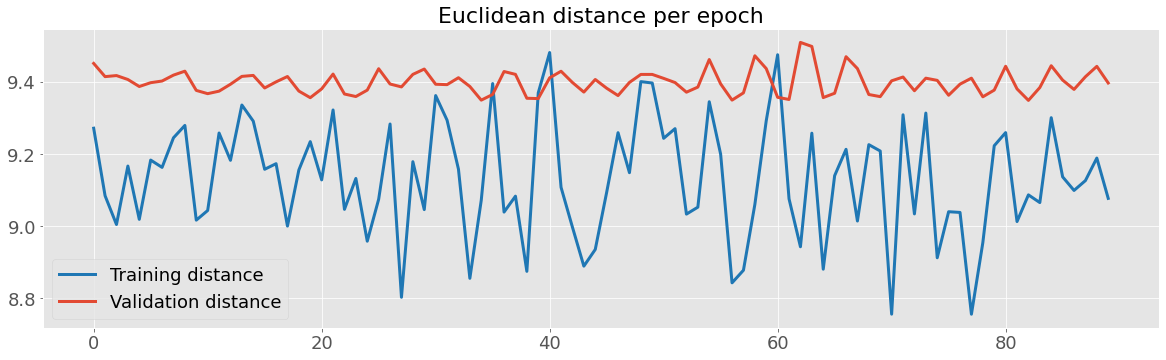

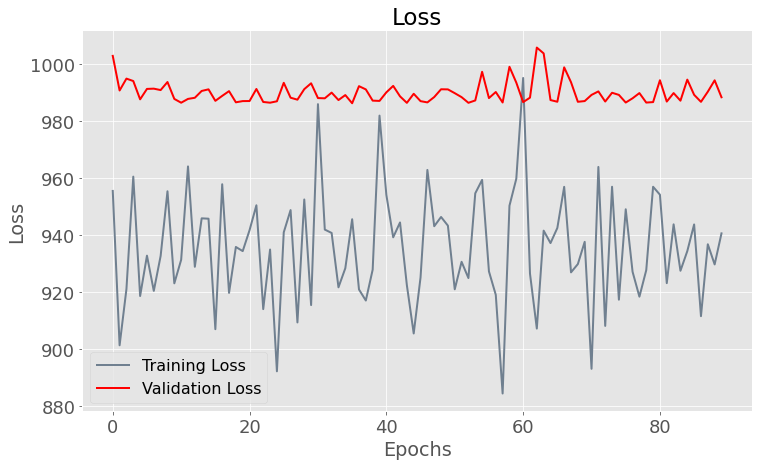

In [11]:
plot.plot_euclidean_distance(train_dis, test_dis)
plot.plot_losses(train_loss[10:], test_loss[10:])

### Histogram of the distribution shift (for test and training distances)

Training set 



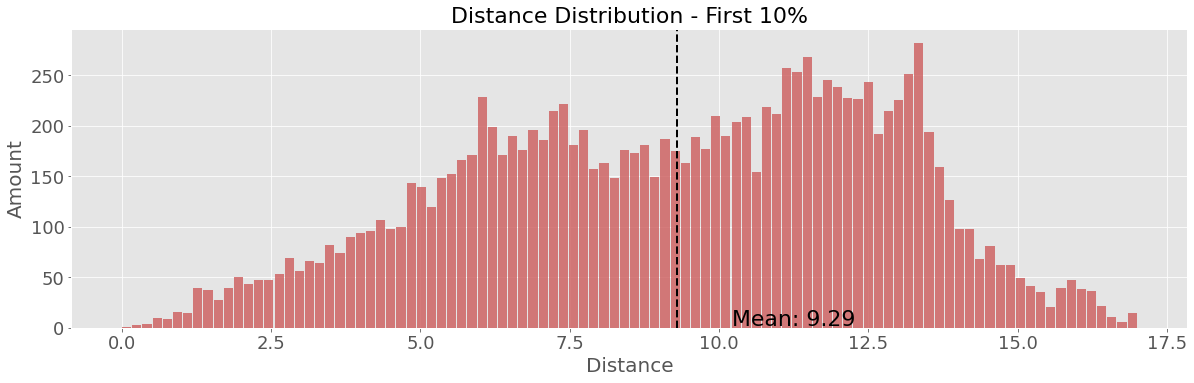

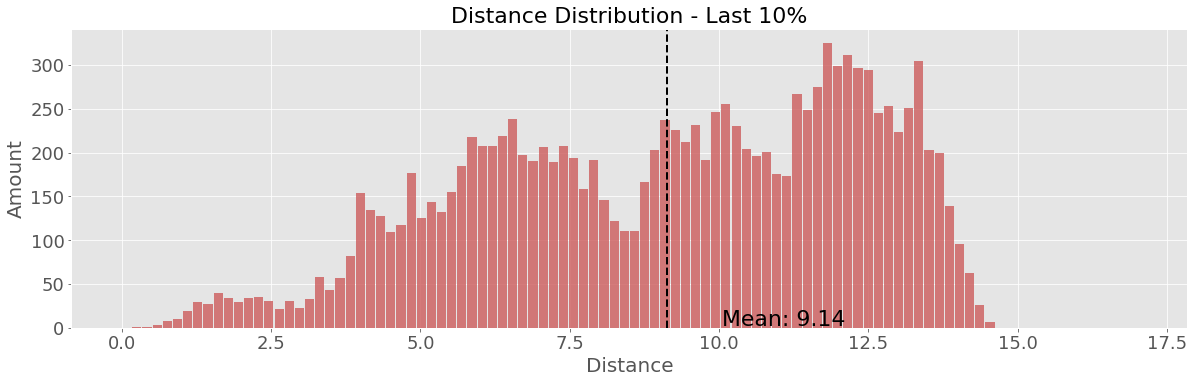

Validation set 



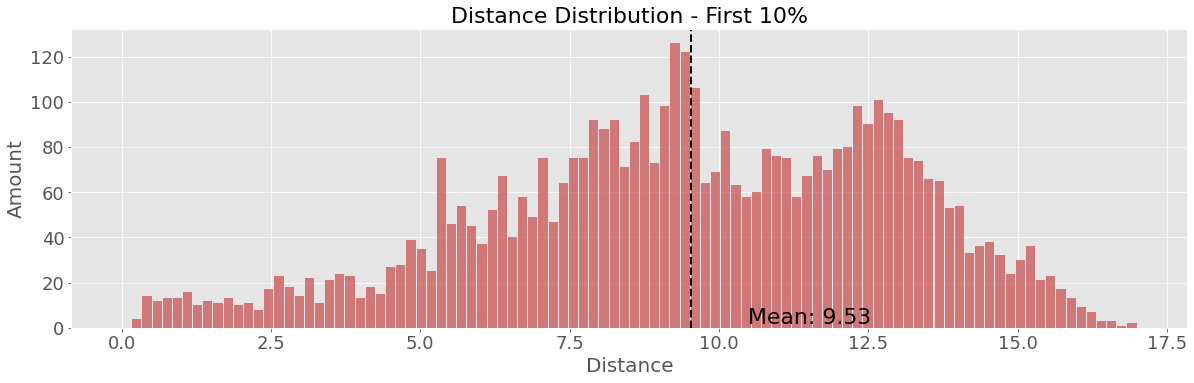

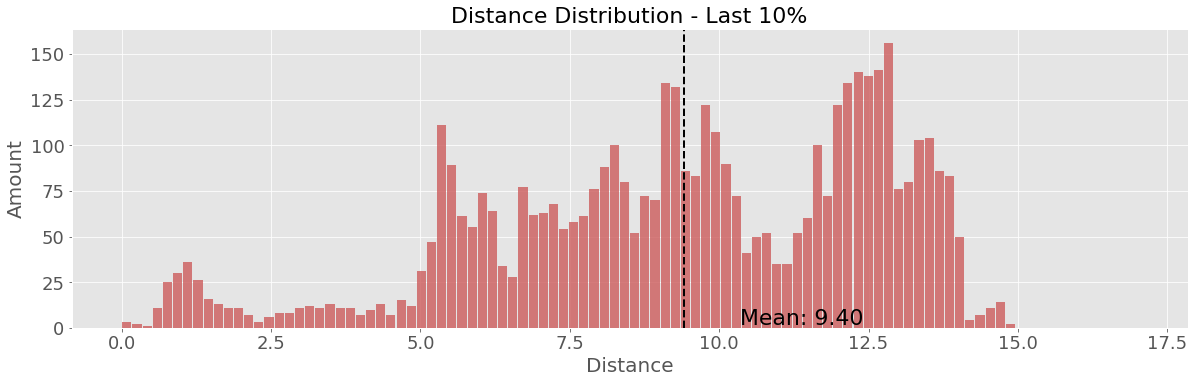

In [12]:
print("Training set \n")
plot.histo_distribution_shift(train_dis_item)
print("Validation set \n")
plot.histo_distribution_shift(test_dis_item)

### Histograms showing the training and validation distance distribution (for test and training distances)

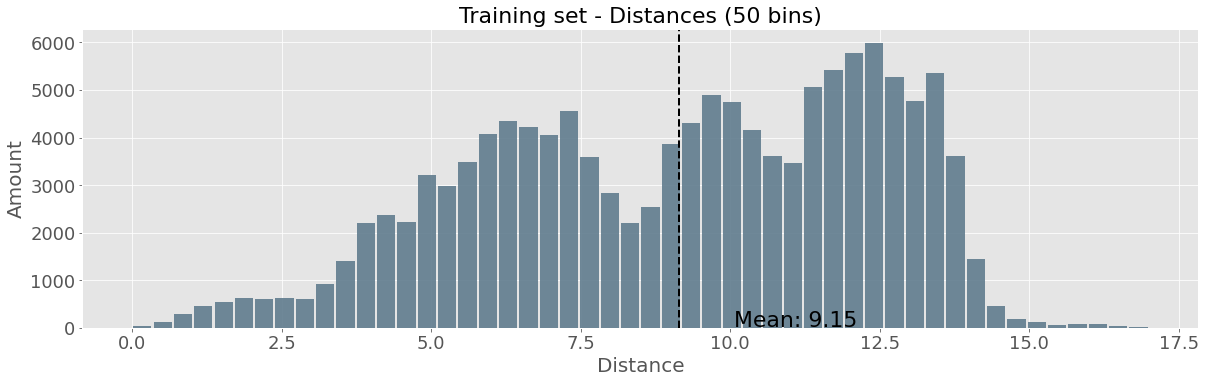

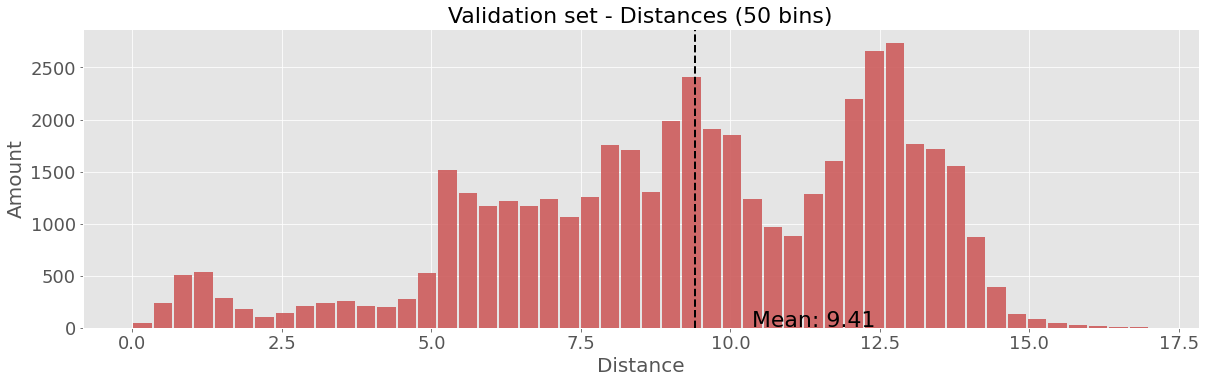

In [13]:
plot.histo_train_val(test_dis_item, train_dis_item)

### Save and load models